In [15]:
import requests, time, random
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
from selenium.webdriver.common.keys import Keys
#!pip install psycopg2
import psycopg2
import pandas.io.sql as psql

In [16]:
#fetching the scrapped data from database


try:
    connection= psycopg2.connect(user="postgres",password="root",host="127.0.0.1", port="5432",database="Biat_Client_Scorer_DataWarehouse")
    
    postgre_Query = 'select CUS."CODE_CLIENT",CUS."NAME_LASTNAME", CUS."DESCRIPTION", CRE."MONTANT_",  MVT."NBR_MVT" from "DATA_CUSTOMER" CUS, "DATA_CREDIT" CRE , "DATA_NBR_MVT" MVT , "CLIENT_SCORE" SCO where "FLAGGED" = 1 AND CUS."CODE_CLIENT" = SCO."CODE_CLIENT" AND CRE."DATA_CREDIT_PK" = SCO."DATA_CREDIT_PK" AND MVT."DATA_NBR_MVT_PK" = SCO."DATA_NBR_MVT_PK" ORDER BY CUS."CODE_CLIENT"  ;'

    df = psql.read_sql(postgre_Query, connection)
    if(connection):
        connection.close()
        print("PostgreSQL connection is closed")

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

PostgreSQL connection is closed


In [17]:
df

,CODE_CLIENT,NAME_LASTNAME,DESCRIPTION,MONTANT_,NBR_MVT
0,123741,OUNI Shaima,Ingénieur JEE/Angular chez Banque Internation...,140000.0,29
1,123789,Ghada Saguer Trabelsi,IT Analyst Data chez BIAT,140000.0,29
2,123852,Marwene Elhechmi,Ingénieur Full Stack Python/Java/JavaEE/Spring...,160000.0,29
3,123963,Heithem Dridi,Analyste Developpeur BI BigData chez BIAT\nTal...,140000.0,29


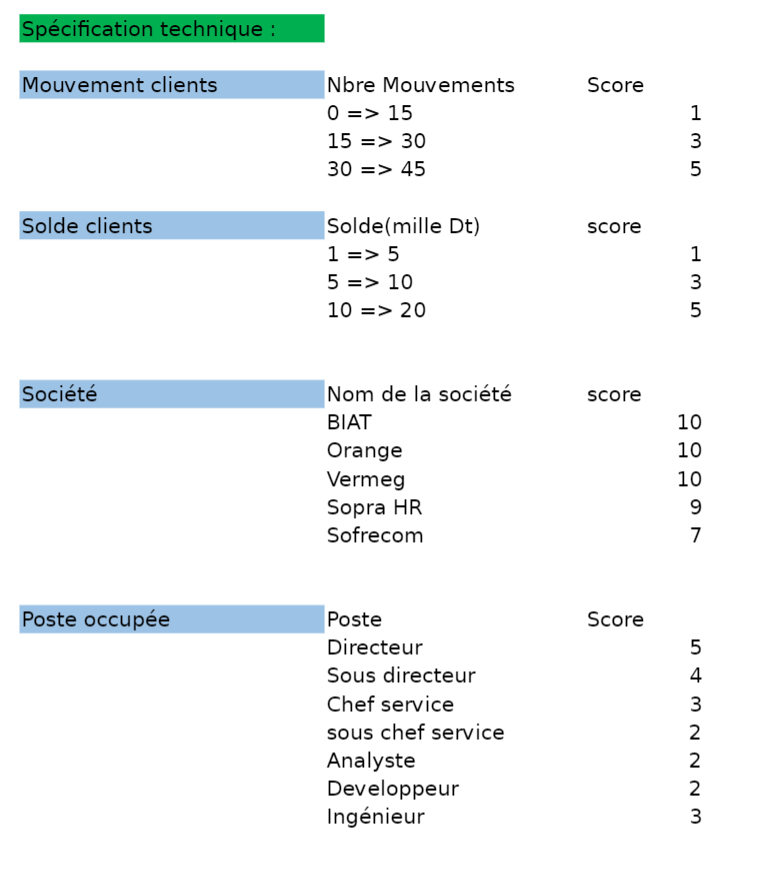!

In [34]:
#Note that the default score if the post doesn't exist in posts is 0
#it can be changed to the mean of scores for example

#Also note that you can add a new limit to the dictionary posts below for futrue scalability

def post_score(post):
    post=post.lower()
    posts={ "sous directeur": 4,"assistant director" :4, "directeur": 5,"director":5, "sous chef service": 2,"under department head":2, "chef service": 3,"department head":3 , "ingénieur" : 3 , "engineer" : 3, "analyste" : 2,"analyst":2, "developpeur" : 2,"developper":2 }
    for p in list(posts.keys()):
        if (post.find(p)>=0):
            return posts[p]
    return 0
    

In [35]:
#testing post_score
#should return 3
post_score(df['DESCRIPTION'][1])

2

In [36]:
#Note that the default score if the company doesn't exist in companies is 0
#it can be changed to the mean of scores for example

#Also note that you can add a new limit to the dictionary companies below for futrue scalability

def company_score(company):
    company=company.upper()
    companies={ "BIAT": 10, "ORANGE":10,"VERMEG":10,"SOPRA HR":9,"SOFRECOM":"7" }
    for c in list(companies.keys()):
        if(company.find(c)>0):
            return companies[c]
    return 0

In [37]:
#testing company_score
#should return 10
company_score(df['DESCRIPTION'][1])

10

In [38]:
#Note that the default score if the balance is greater than 20000 dt is 5
#it can be changed to an arbitrary value later

#Also note that you can add a new limit to the dictionary balance_limits below for futrue scalability

def balance_score(balance):
    balance_limits={  5000:1  ,  10000:3  ,  20000:5  }
    for b in list(balance_limits.keys()):
        if(balance<b):
            return balance_limits[b]
    return 5
    

In [39]:
#testing balance_score
#should return 5
balance_score(df['MONTANT_'][1])

5

In [40]:
#Note that the default score if the number of client transactions is greater than 45 dt is 5
#it can be changed to an arbitrary value later

#Also note that you can add a new limit to the dictionary transactions_limits below for future scalability

def transactions_score(transaction):
    transactions_limits={  15:1  ,  35:3  ,  45:5  }
    for t in list(transactions_limits.keys()):
        if(transaction<t):
            return transactions_limits[t]
    return 5
    

In [41]:
#testing transactions_score
#should return 3

transactions_score(df['NBR_MVT'][1])

3

In [42]:
#After defining our management rules we will:
#    calculate each client's score
#    add a column score with the new value
#    update the database


scores={'SCORE':[]}
for i in range(len(df)):
    client_score=0
    #print(df['CODE_CLIENT'][i])
    client_score=client_score+transactions_score(df['NBR_MVT'][i])+balance_score(df['MONTANT_'][i])+post_score(df['DESCRIPTION'][i])+company_score(df['DESCRIPTION'][i])
    scores['SCORE'].append(client_score)
score_df=pd.DataFrame(scores,columns=['SCORE'])
final_df=df.join(score_df)


In [43]:
final_df

,CODE_CLIENT,NAME_LASTNAME,DESCRIPTION,MONTANT_,NBR_MVT,SCORE
0,123741,OUNI Shaima,Ingénieur JEE/Angular chez Banque Internation...,140000.0,29,21
1,123789,Ghada Saguer Trabelsi,IT Analyst Data chez BIAT,140000.0,29,20
2,123852,Marwene Elhechmi,Ingénieur Full Stack Python/Java/JavaEE/Spring...,160000.0,29,21
3,123963,Heithem Dridi,Analyste Developpeur BI BigData chez BIAT\nTal...,140000.0,29,20


In [44]:
#Updating database
try:
    connection= psycopg2.connect(user="postgres",password="root",host="127.0.0.1", port="5432",database="Biat_Client_Scorer_DataWarehouse")
    cursor=connection.cursor()

    for k in range(len(final_df)):

        postgre_update_query = 'UPDATE "CLIENT_SCORE" SET  "SCORE_CLIENT" = %s where "CODE_CLIENT" = %s;'
        cursor.execute(postgre_update_query,(final_df['SCORE'][k].item(),final_df['CODE_CLIENT'][k].item()))
        connection.commit()

    if(connection):
        connection.close()
        print("PostgreSQL connection is closed")

except (Exception, psycopg2.Error) as error :
    print ("Error while fetching data from PostgreSQL", error)

PostgreSQL connection is closed
